In [93]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.linear_model import LogisticRegression

import pydot

# 데이터 처리

In [36]:
df_hr = pd.read_csv("HR_comma_sep.csv")

In [37]:
df_hr['sales'].replace(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
        'IT', 'product_mng', 'marketing', 'RandD'], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], inplace = True)
df_hr['salary'].replace(['low', 'medium', 'high'], [0, 1, 2], inplace = True)

In [38]:
df_hr.columns

Index([u'satisfaction_level', u'last_evaluation', u'number_project',
       u'average_montly_hours', u'time_spend_company', u'Work_accident',
       u'left', u'promotion_last_5years', u'sales', u'salary'],
      dtype='object')

In [39]:
df_hr[[u'satisfaction_level', u'last_evaluation', u'number_project',
       u'average_montly_hours', u'time_spend_company', u'Work_accident',
       u'left', u'promotion_last_5years', u'sales', u'salary']] = minmax_scale(df_hr)

In [40]:
label = df_hr['left']

# train set과 test set 구분하기

In [86]:
from sklearn.model_selection import train_test_split
label = df_hr["left"]
data = df_hr.drop(["left"],axis=1)
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size = 0.2, random_state = 42)

# logistic regression

In [87]:
logis = LogisticRegression()
logis.fit(data_train, label_train)
logis_score_train = logis.score(X_train, y_train)
print("Training score: ",logis_score_train)
logis_score_test = logis.score(X_test, y_test)
print("Testing score: ",logis_score_test)

Training score:  0.788732394366
Testing score:  0.786666666667


# SVC

In [88]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(data_train, label_train)
svm_score_train = svm.score(X_train, y_train)
print("Training score: ",svm_score_train)
svm_score_test = svm.score(X_test, y_test)
print("Testing score: ",svm_score_test)

Training score:  0.922576881407
Testing score:  0.926666666667


# KNN 

In [89]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(data_train, label_train)
knn_score_train = knn.score(X_train, y_train)
print("Training score: ",knn_score_train)
knn_score_test = knn.score(X_test, y_test)
print("Testing score: ",knn_score_test)

Training score:  0.966580548379
Testing score:  0.955666666667


# Random forest

In [90]:

rfc = RandomForestClassifier()
rfc.fit(data_train, label_train)
rfc_score_train = rfc.score(X_train, y_train)
print("Training score: ",rfc_score_train)
rfc_score_test = rfc.score(X_test, y_test)
print("Testing score: ",rfc_score_test)

Training score:  0.998083173598
Testing score:  0.991


# decision tree

In [77]:
kfold = StratifiedKFold(y_train,n_folds=10,random_state=2)
DTC = DecisionTreeClassifier(max_depth=3)
cv_results = cross_val_score(DTC,X_train, y_train, cv=kfold, scoring="accuracy")
cv_results.mean()

0.95266297123585952

In [78]:
DTC.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

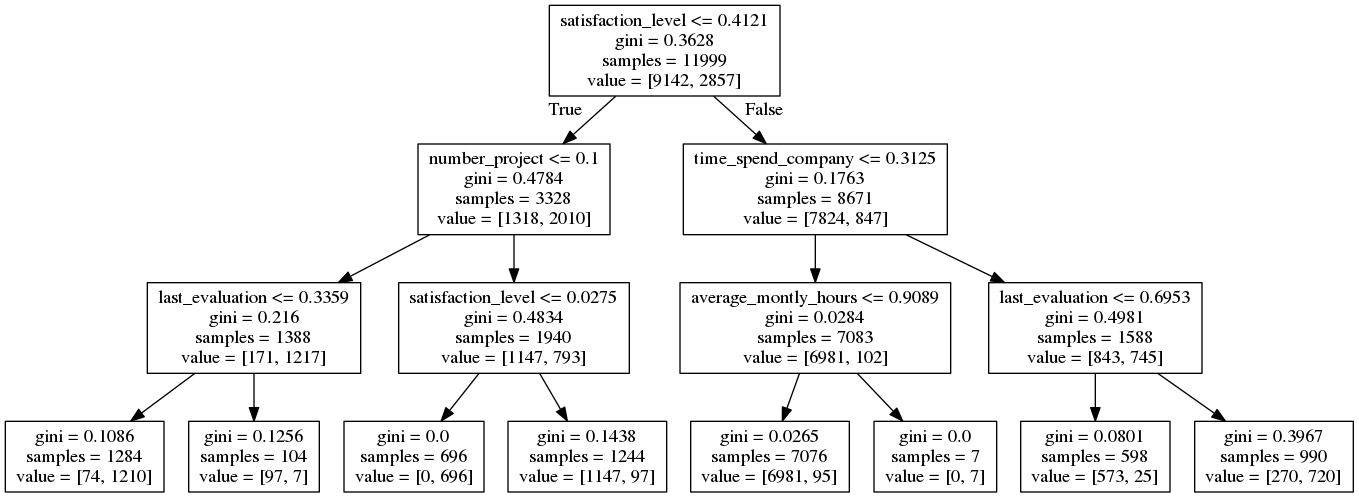

In [82]:
dot_data = StringIO()

tree.export_graphviz(DTC, out_file=dot_data,feature_names=train_features)

graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]
graph.set_lwidth(400)
graph.set_lheight(300)

Image(graph.create_png())


# Tensor flow(추가필요) - aws익힌 후 다시 

In [125]:
tf.set_random_seed(777)  # for reproducibility
learning_rate = 0.1

x_data = X_train
y_data = y_train

x_data = np.array(x_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.float32)

X = tf.placeholder(tf.float32, [None, 9])
Y = tf.placeholder(tf.float32, [None])

W1 = tf.Variable(tf.random_normal([9, 20]), name='weight1')
b1 = tf.Variable(tf.random_normal([20]), name='bias1')
layer2 = tf.nn.sigmoid(tf.matmul(X, W1) + b1)

W2 = tf.Variable(tf.random_normal([20, 1]), name='weight2')
b2 = tf.Variable(tf.random_normal([1]), name='bias2')
hypothesis = tf.nn.sigmoid(tf.matmul(layer2, W2) + b2)

# cost/loss function
cost = -tf.reduce_mean(Y * tf.log(hypothesis) + (1 - Y) *
                       tf.log(1 - hypothesis))

train = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy computation
# True if hypothesis>0.5 else False
predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, Y), dtype=tf.float32))

# Launch graph
with tf.Session() as sess:
    # Initialize TensorFlow variables
    sess.run(tf.global_variables_initializer())

    for step in range(100):
        sess.run(train, feed_dict={X: x_data, Y: y_data})
        if step % 10 == 0:
            print(step, sess.run(cost, feed_dict={
                  X: x_data, Y: y_data}), sess.run([W1, W2]))

    # Accuracy report
    h, c, a = sess.run([hypothesis, predicted, accuracy],
                       feed_dict={X: x_data, Y: y_data})
    print("\nAccuracy: ", a)

0 1.29462 [array([[ -4.04654235e-01,  -1.36923417e-02,   4.41459596e-01,
         -1.12087750e+00,   2.98734405e-03,  -6.34484589e-02,
          1.24599517e-03,   3.36793751e-01,  -1.20441929e-01,
         -4.56949949e-01,   8.23922515e-01,   1.60801578e-02,
          7.46848226e-01,   2.87793845e-01,  -1.02348246e-01,
          2.72936165e-01,   2.54589021e-01,  -1.55586278e+00,
         -3.18707556e-01,   6.73712134e-01],
       [  1.60097146e+00,  -6.26823366e-01,   1.37912050e-01,
          9.04105425e-01,  -1.10845304e+00,  -2.06130338e+00,
         -1.35701165e-01,  -6.89234316e-01,   9.12171841e-01,
         -1.34015039e-01,   1.28139302e-01,  -9.80359912e-01,
         -8.95268738e-01,  -4.97140527e-01,   5.66384047e-02,
          1.63042748e+00,  -9.34898019e-01,  -1.11055881e-01,
         -2.22753152e-01,   5.35142601e-01],
       [ -5.16770899e-01,   8.21863592e-01,  -1.43690157e+00,
         -2.03446850e-01,  -6.79149568e-01,   3.22859144e+00,
         -1.15570672e-01,  -2.3

KeyboardInterrupt: 

In [ ]:
from sklearn.naive_bayes import MultinomialNB